<a href="https://colab.research.google.com/github/git-parth-ch/Tumor-Classification-Mammogram/blob/main/Tumor_Classification_10k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
upload = files.upload()  # Upload
mass_df = pd.read_csv("mass_case_description_train_set_augmented_10k.csv")

Saving mass_case_description_train_set_augmented_10k.csv to mass_case_description_train_set_augmented_10k (3).csv


In [ ]:
print("\n--- First 5 Rows of Data ---")
print(mass_df.head())


print("\n--- Info Before Cleaning ---")
mass_df.info()

print("\n--- Null Value Count Before Cleaning ---")
print(mass_df.isnull().sum())


--- First 5 Rows of Data ---
  patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00001             3.0                 LEFT         CC             1.0   
1    P_00001             3.0                 LEFT        MLO             1.0   
2    P_00004             3.0                 LEFT         CC             1.0   
3    P_00004             3.0                 LEFT        MLO             1.0   
4    P_00004             3.0                RIGHT        MLO             1.0   

  abnormality type                          mass shape   mass margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0         4.

In [ ]:

# Drop duplicate rows
df = mass_df.drop_duplicates()

# Replace 'breast_density' with a more convenient name
df.rename(columns={'breast_density': 'breast density'}, inplace=True)

# Fill missing categorical columns with "Unknown"
for col in ['mass shape', 'mass margins']:
    df[col].fillna('Unknown', inplace=True)

/tmp/ipython-input-602586547.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace=True)


In [ ]:
# Encode pathology (target variable)
df['pathology'] = df['pathology'].replace('BENIGN_WITHOUT_CALLBACK', 'BENIGN')
df['pathology'] = df['pathology'].map({'MALIGNANT': 1, 'BENIGN': 0})

print("\n--- Cleaned Pathology Values ---")
print(df['pathology'].value_counts())


--- Cleaned Pathology Values ---
pathology
0    6372
1    5946
Name: count, dtype: int64


In [ ]:
# Drop columns not useful for training
columns_to_drop = [
    'patient_id',
    'abnormality id',
    'image file path',
    'cropped image file path',
    'ROI mask file path'
]
df_cleaned = df.drop(columns=columns_to_drop)

print("\n--- Missing Values After Cleaning ---")
print(df_cleaned.isnull().sum())

print("\n--- First 5 Rows of Cleaned Data ---")
print(df_cleaned.head())


--- Missing Values After Cleaning ---
breast density          0
left or right breast    0
image view              0
abnormality type        0
mass shape              0
mass margins            0
assessment              0
pathology               0
subtlety                0
dtype: int64

--- First 5 Rows of Cleaned Data ---
   breast density left or right breast image view abnormality type  \
0             3.0                 LEFT         CC             mass   
1             3.0                 LEFT        MLO             mass   
2             3.0                 LEFT         CC             mass   
3             3.0                 LEFT        MLO             mass   
4             3.0                RIGHT        MLO             mass   

                           mass shape   mass margins  assessment  pathology  \
0  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED         4.0          1   
1  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED         4.0          1   
2            ARCHI

In [ ]:
X = df_cleaned.drop('pathology', axis=1)
y = df_cleaned['pathology']

# One-hot encoding for categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

print("\n--- Shape of Encoded Data ---")
print(X_encoded.shape)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)


--- Shape of Encoded Data ---
(12318, 38)


In [ ]:
#  Stratified K-Fold Cross-Validation
print("\n--- Starting 5-Fold Cross-Validation ---")

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
accuracies = []

for train_index, test_index in kf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = SVC(kernel='rbf', C=1.0, gamma='auto')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"\n--- Fold {fold}/5 ---")
    print(f"Fold {fold} Test Accuracy: {acc:.4f}")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

    fold += 1

print("\n--- Cross-Validation Summary ---")
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
print(f"Mean Accuracy: {np.mean(accuracies):.4f}({mean_acc * 100:.2f}%)")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


--- Starting 5-Fold Cross-Validation ---

--- Fold 1/5 ---
Fold 1 Test Accuracy: 0.8925
TP: 1072, TN: 1127, FP: 147, FN: 118

--- Fold 2/5 ---
Fold 2 Test Accuracy: 0.8908
TP: 1058, TN: 1137, FP: 138, FN: 131

--- Fold 3/5 ---
Fold 3 Test Accuracy: 0.8937
TP: 1066, TN: 1136, FP: 139, FN: 123

--- Fold 4/5 ---
Fold 4 Test Accuracy: 0.8924
TP: 1047, TN: 1151, FP: 123, FN: 142

--- Fold 5/5 ---
Fold 5 Test Accuracy: 0.9050
TP: 1071, TN: 1158, FP: 116, FN: 118

--- Cross-Validation Summary ---
Mean Accuracy: 0.8949(89.49%)
Standard Deviation: 0.0051


In [ ]:
# Final Train/Test Split Evaluation

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

best_model = SVC(kernel='rbf', C=1.0, gamma='auto')
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("\n--- Final Evaluation on Hold-Out Test Set ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['BENIGN', 'MALIGNANT']))


--- Final Evaluation on Hold-Out Test Set ---
Accuracy: 0.8973214285714286

Classification Report:
               precision    recall  f1-score   support

      BENIGN       0.90      0.90      0.90      1275
   MALIGNANT       0.90      0.89      0.89      1189

    accuracy                           0.90      2464
   macro avg       0.90      0.90      0.90      2464
weighted avg       0.90      0.90      0.90      2464




TP: 1059, TN: 1152, FP: 123, FN: 130


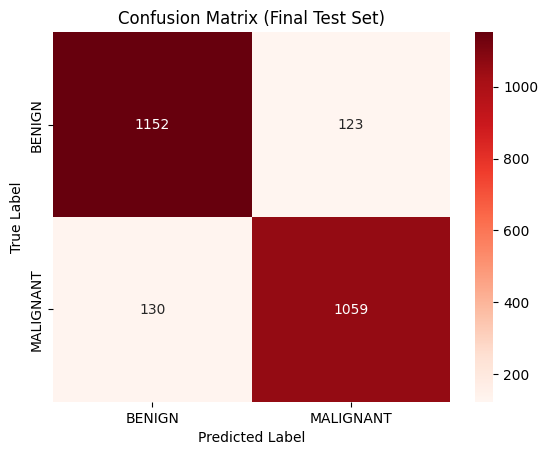

In [ ]:
# Confusion Matrix
cm_final = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm_final.ravel()
print(f"\nTP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

sns.heatmap(cm_final, annot=True, fmt='d', cmap='Reds',
            xticklabels=['BENIGN', 'MALIGNANT'],
            yticklabels=['BENIGN', 'MALIGNANT'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Final Test Set)')
plt.show()


# Mass Case Description Analysis and SVM Classification

This notebook analyzes the `mass_case_description_train_set_augmented_10k.csv` dataset and builds a Support Vector Machine (SVM) model to classify breast mass pathology as either benign or malignant.

## Project Description

The goal of this project is to preprocess and analyze a dataset containing information about breast masses and train a classification model to predict the likelihood of a mass being malignant based on its characteristics.

## Dataset

The dataset used in this project is `mass_case_description_train_set_augmented_10k.csv`. It contains various features related to breast masses, including breast density, image view, mass shape, mass margins, assessment, and pathology.

## Analysis and Modeling Steps

The notebook performs the following steps:

1.  **Data Loading and Initial Inspection:**
    -   Loads the dataset using pandas.
    -   Displays the first few rows, data types, and checks for missing values.

2.  **Data Cleaning and Preprocessing:**
    -   Removes duplicate rows.
    -   Renames the 'breast_density' column.
    -   Fills missing values in 'mass shape' and 'mass margins' with "Unknown".
    -   Encodes the 'pathology' column, merging 'BENIGN_WITHOUT_CALLBACK' into 'BENIGN' and mapping 'MALIGNANT' to 1 and 'BENIGN' to 0.
    -   Drops columns not relevant for training the model (patient ID, abnormality ID, image file paths).

3.  **Feature Engineering and Scaling:**
    -   Separates features (X) and the target variable (y).
    -   Applies one-hot encoding to categorical features in X.
    -   Standardizes the features using StandardScaler.

4.  **Model Training and Evaluation (Cross-Validation):**
    -   Uses Stratified K-Fold cross-validation (with 5 splits) to evaluate the SVM model's performance.
    -   Trains an SVM model with a radial basis function (rbf) kernel.
    -   Reports the accuracy, true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) for each fold.
    -   Calculates and prints the mean accuracy and standard deviation across all folds.

5.  **Final Model Evaluation (Train/Test Split):**
    -   Splits the data into a training set (80%) and a hold-out test set (20%) using `train_test_split` with stratification.
    -   Standardizes the training and test sets separately.
    -   Trains the final SVM model on the training data.
    -   Evaluates the model on the hold-out test set.
    -   Prints the accuracy and a detailed classification report (precision, recall, f1-score).

6.  **Confusion Matrix Visualization:**
    -   Generates and displays a confusion matrix for the final model's predictions on the test set.
    -   Visualizes the confusion matrix using a heatmap.

## Results

The cross-validation and final test set evaluation show that the SVM model achieves a mean accuracy of approximately 89.5% in classifying breast mass pathology. The confusion matrix provides a detailed breakdown of the model's performance in terms of correctly and incorrectly classified instances.

## How to Run the Notebook

1.  Upload the `mass_case_description_train_set_augmented_10k.csv` file to your Colab environment.
2.  Run each code cell sequentially.

## Dependencies

The following libraries are required to run this notebook:

-   pandas
-   numpy
-   matplotlib
-   seaborn
-   sklearn